In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse

import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler,Subset

import matplotlib.pyplot as plt


In [6]:
from utils import *
#from aspp import DeepLabHead
#from create_dataset import NYUv2
from LibMTL import Trainer
#from LibMTL.model import resnet_dilated
from LibMTL.model.resnet import resnet50
from LibMTL.utils import set_random_seed, set_device
from LibMTL.config import LibMTL_args, prepare_args


In [7]:
from LibMTL.loss import CELoss,  FocalLoss
from LibMTL.metrics import F1Metric, AccMetric
from LibMTL._record import _PerformanceMeter


## Argument Parsing

In [22]:

import argparse
import sys

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--csv_file', default='/home3/jqwx33/SculptureMTL/sculpture-multi-class-remove-unknown.csv', type=str, help='path to the csv file')
    parser.add_argument('--img_dir', default='/home3/jqwx33/SculptureMTL/selected_images', type=str, help='directory of images')
    parser.add_argument('--train_bs', default=10,type=int, help='batch size for training')
    parser.add_argument('--test_bs', default=10, type=int, help='batch size for testing')
    parser.add_argument('--epochs', default=30,type=int, help='training epochs')
    parser.add_argument('--weighting', default='DWA', type=str, help='weighting strategy')
    parser.add_argument('--arch', default='MTAN', type=str, help='MTL architecture')
    parser.add_argument('--gpu_id', default='0', type=str, help='gpu id')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--scheduler', default='step', type=str, help='learning rate scheduler type')
    parser.add_argument('--optim', default='adamw', type=str, help='optimizer type')
    parser.add_argument('--mode', default='train', type=str, help='mode: train or test')
    
    parser.add_argument('--save_path', default='/home3/jqwx33/SculptureMTL/result-ma2', type=str, help='save path')
    parser.add_argument('--load_path', default=None, type=str, help='load path for testing')
    parser.add_argument('--T', default=2, type=int, help='DWA parameter T')
    parser.add_argument('--step_size', default=50, type=int, help='scheduler step size')
    parser.add_argument('--gamma', default=0.5, type=float, help='scheduler gamma')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=0.0005, type=float, help='weight decay')
    parser.add_argument('--rep_grad', action='store_true', default=False, help='compute representative gradients')
    parser.add_argument('--multi_input', action='store_true', default=False, help='multi-input')
    if sys.argv and sys.argv[0].endswith('ipykernel_launcher.py'):
        args = parser.parse_args(args=[])
    else:
        args = parser.parse_args()
    return args


## Dataset  Definition

In [23]:


class SculptureDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        self.image_paths = self.data['image_path'].tolist()
  
        self.materials_col = 'materials_encoded'
#         self.genres_col = 'genres_encoded'
#         self.time_period_col = 'years_encoded'
        
         # Remove any rows with NaN values
        #self.data = self.data.dropna(subset=[self.materials_col, self.genres_col, self.time_period_col])

        self.data[self.materials_col] = self.data[self.materials_col].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)
#         self.data[self.genres_col] = self.data[self.genres_col].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)
#         self.data[self.time_period_col] = pd.to_numeric(self.data[self.time_period_col], errors='coerce').fillna(0).astype(np.int64)


   
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        materials = self.data.iloc[idx][self.materials_col].astype(np.int64)
#         genres = self.data.iloc[idx][self.genres_col].astype(np.int64)
#         time_period = self.data.iloc[idx][self.time_period_col].astype(np.int64)

        return image, {'materials': torch.tensor(materials, dtype=torch.long)}


        
# Reshape layer for decoder
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
    

## Model and Training Configuration


In [25]:
#train
# Main function to set up and run the model
def main(params):
    
    if not os.path.exists(params.save_path):
        os.makedirs(params.save_path)
        

    # Prepare arguments for optimizer and scheduler
    kwargs, optim_param, scheduler_param = prepare_args(params)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(30),      # Randomly rotate the image by 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  

    ])

    dataset = SculptureDataset(csv_file=params.csv_file, img_dir=params.img_dir, transform=transform)

    train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, random_state=params.seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=params.seed)  

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)
    

    train_loader = DataLoader(train_set, batch_size=params.train_bs, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)


    # Define tasks and metrics
    # Define tasks and metrics
    task_dict = {
        'materials': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        }

    }
    
    # Function to return the encoder class
    def encoder_class():
        return resnet50(pretrained=True)

    class SculptureEncoder(nn.Module):
        def __init__(self):
            super(SculptureEncoder, self).__init__()
            self.encoder = resnet50(pretrained=True)  

        def forward(self, x):
            x = self.encoder(x)
            print("Encoder output shape:", x.shape)
            return x




    # Initialize encoder to get the output shape
    
    encoder = SculptureEncoder()
    dummy_input = torch.randn(1, 3, 256, 256)
    encoder_output = encoder(dummy_input)
    flattened_size = encoder_output.view(1, -1).size(1)
    
    num_out_channels = {
    'materials': len(np.unique(dataset.data[dataset.materials_col]))
    #'genres': len(np.unique(dataset.data[dataset.genres_col])),
    #'time_period': len(np.unique(dataset.data[dataset.time_period_col]))
}

    
    #Decoder class for each task
    class Decoder(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(Decoder, self).__init__()
            self.decoder = nn.Sequential(
                ReshapeLayer(),
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(512, output_dim),
            )
        def forward(self, x):
            return self.decoder(x)
        

#     class Decoder(nn.Module):
#         def __init__(self, input_dim, output_dim):
#             super(Decoder, self).__init__()
#             self.decoder = nn.Sequential(
#                 ReshapeLayer(),
#                 nn.Linear(input_dim, output_dim)
#             )

#         def forward(self, x):
#             return self.decoder(x)

    decoders = nn.ModuleDict({task: Decoder(flattened_size, num_out_channels[task]) for task in task_dict.keys()})
    
    
    # Trainer class for the sculpture model

    class SculptureTrainer(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class, decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(SculptureTrainer, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, **kwargs)
            

        def process_preds(self, preds):
            return preds

        def _process_data(self, loader):
            try:
                data, label = next(loader[1])
            except:
                loader[1] = iter(loader[0])
                data, label = next(loader[1])
            inputs = data.to(self.device, non_blocking=True)
            labels = {task: label[task].to(self.device, non_blocking=True) for task in self.task_name}
            return inputs, labels




    SculptureModel = SculptureTrainer(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders,
                                      rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param,
                                      save_path=params.save_path, load_path=params.load_path, **kwargs)

    if params.mode == 'train':
        try:
            SculptureModel.train(train_loader, val_loader, params.epochs)


        finally:
            torch.cuda.empty_cache()
    elif params.mode == 'test':
        try:
            SculptureModel.test(test_loader)
        finally:
            torch.cuda.empty_cache()
    else:
        raise ValueError("Invalid mode. Choose between 'train' and 'test'.")

if __name__ == "__main__":
    params = parse_args()
    set_device(params.gpu_id)
    set_random_seed(params.seed)
    main(params)


General Configuration:
	Mode: train
	Wighting: DWA
	Architecture: MTAN
	Rep_Grad: False
	Multi_Input: False
	Seed: 0
	Save Path: /home3/jqwx33/SculptureMTL/result-ma2
	Load Path: None
	Device: cuda:0
DWA Configuration:
	T: 2
Optimizer Configuration:
	optim: adamw
	lr: 0.001
	weight_decay: 0.0005
Scheduler Configuration:
	scheduler: step
	step_size: 50
	gamma: 0.5
Encoder output shape: torch.Size([1, 2048, 8, 8])
Total Params: 102729353
Trainable Params: 102729353
Non-trainable Params: 0
LOG FORMAT | materials_LOSS acc | TIME
Epoch: 0000 | TRAIN: 2.5389 0.2824 | Time: 60.7506 | TEST: 1.7741 0.2156 | Time: 3.3199
Save Model 0 to /home3/jqwx33/SculptureMTL/result-ma2/best.pt
Epoch: 0001 | TRAIN: 1.6995 0.3399 | Time: 60.3824 | TEST: 1.6403 0.4058 | Time: 3.3214
Save Model 1 to /home3/jqwx33/SculptureMTL/result-ma2/best.pt
Epoch: 0002 | TRAIN: 1.6222 0.4095 | Time: 60.4736 | TEST: 1.6117 0.3877 | Time: 3.2795
Epoch: 0003 | TRAIN: 1.5875 0.4145 | Time: 60.4682 | TEST: 1.7543 0.3859 | Time: 

In [12]:
#test
# Main function to set up and run the model
def main(params):
    
    if not os.path.exists(params.save_path):
        os.makedirs(params.save_path)
        

    # Prepare arguments for optimizer and scheduler
    kwargs, optim_param, scheduler_param = prepare_args(params)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(30),      # Randomly rotate the image by 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    ])

    dataset = SculptureDataset(csv_file=params.csv_file, img_dir=params.img_dir, transform=transform)

    train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, random_state=params.seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=params.seed)  

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)
    

    train_loader = DataLoader(train_set, batch_size=params.train_bs, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)


    # Define tasks and metrics
    # Define tasks and metrics
    task_dict = {
        'materials': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        }

    }
    
    # Function to return the encoder class
    def encoder_class():
        return resnet50(pretrained=True)

    class SculptureEncoder(nn.Module):
        def __init__(self):
            super(SculptureEncoder, self).__init__()
            self.encoder = resnet50(pretrained=True)  

        def forward(self, x):
            x = self.encoder(x)
            print("Encoder output shape:", x.shape)
            return x




    # Initialize encoder to get the output shape
    
    encoder = SculptureEncoder()
    dummy_input = torch.randn(1, 3, 256, 256)
    encoder_output = encoder(dummy_input)
    flattened_size = encoder_output.view(1, -1).size(1)
    
    num_out_channels = {
    'materials': len(np.unique(dataset.data[dataset.materials_col]))
    #'genres': len(np.unique(dataset.data[dataset.genres_col])),
    #'time_period': len(np.unique(dataset.data[dataset.time_period_col]))
}

    
    #Decoder class for each task
    class Decoder(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(Decoder, self).__init__()
            self.decoder = nn.Sequential(
                ReshapeLayer(),
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(512, output_dim),
            )
        def forward(self, x):
            return self.decoder(x)
        

#     class Decoder(nn.Module):
#         def __init__(self, input_dim, output_dim):
#             super(Decoder, self).__init__()
#             self.decoder = nn.Sequential(
#                 ReshapeLayer(),
#                 nn.Linear(input_dim, output_dim)
#             )

#         def forward(self, x):
#             return self.decoder(x)

    decoders = nn.ModuleDict({task: Decoder(flattened_size, num_out_channels[task]) for task in task_dict.keys()})
    
    
    # Trainer class for the sculpture model

    class SculptureTrainer(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class, decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(SculptureTrainer, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, **kwargs)
            

        def process_preds(self, preds):
            return preds

        def _process_data(self, loader):
            try:
                data, label = next(loader[1])
            except:
                loader[1] = iter(loader[0])
                data, label = next(loader[1])
            inputs = data.to(self.device, non_blocking=True)
            labels = {task: label[task].to(self.device, non_blocking=True) for task in self.task_name}
            return inputs, labels




    SculptureModel = SculptureTrainer(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders,
                                      rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param,
                                      save_path=params.save_path, load_path=params.load_path, **kwargs)

    if params.mode == 'train':
        try:
            SculptureModel.train(train_loader, val_loader, params.epochs)


        finally:
            torch.cuda.empty_cache()
    elif params.mode == 'test':
        try:
            SculptureModel.test(test_loader)
        finally:
            torch.cuda.empty_cache()
    else:
        raise ValueError("Invalid mode. Choose between 'train' and 'test'.")

if __name__ == "__main__":
    params = parse_args()
    set_device(params.gpu_id)
    set_random_seed(params.seed)
    main(params)


General Configuration:
	Mode: test
	Wighting: DWA
	Architecture: MTAN
	Rep_Grad: False
	Multi_Input: False
	Seed: 0
	Save Path: /home3/jqwx33/SculptureMTL/result-ma2
	Load Path: /home3/jqwx33/SculptureMTL/result-ma2/best.pt
	Device: cuda:0
DWA Configuration:
	T: 2
Optimizer Configuration:
	optim: adamw
	lr: 0.001
	weight_decay: 0.0005
Scheduler Configuration:
	scheduler: step
	step_size: 50
	gamma: 0.5
Encoder output shape: torch.Size([1, 2048, 8, 8])
Load Model from - /home3/jqwx33/SculptureMTL/result-ma2/best.pt
Total Params: 102729353
Trainable Params: 102729353
Non-trainable Params: 0
LOG FORMAT | materials_LOSS acc | TIME
TEST: 1.4243 0.5380 | Time: 3.9226


## Compare with MTL

In [8]:
val_acc_materials = [0.2156, 0.4058, 0.3877, 0.3859, 0.3931, 0.3949, 0.3931, 0.4112, 0.3696, 0.4475, 0.3659, 0.4185, 0.4221, 0.3859, 0.3587, 0.3641, 0.3986, 0.4040, 0.4203, 0.4348, 0.4275, 0.4330, 0.4583, 0.4475, 0.4293, 0.4529, 0.4257, 0.4674, 0.4402, 0.4511]
val_acc_materials2 = [0.3152, 0.3261, 0.4076, 0.4149, 0.4457, 0.4348, 0.4764, 0.4239, 0.4384, 0.4511, 0.4330, 0.3859, 0.4529, 0.4493, 0.4221, 0.4384, 0.4438, 0.4366, 0.4511, 0.4547, 0.4402, 0.4620, 0.4638, 0.4438, 0.4384, 0.4710, 0.4565, 0.4511, 0.4420, 0.4438]


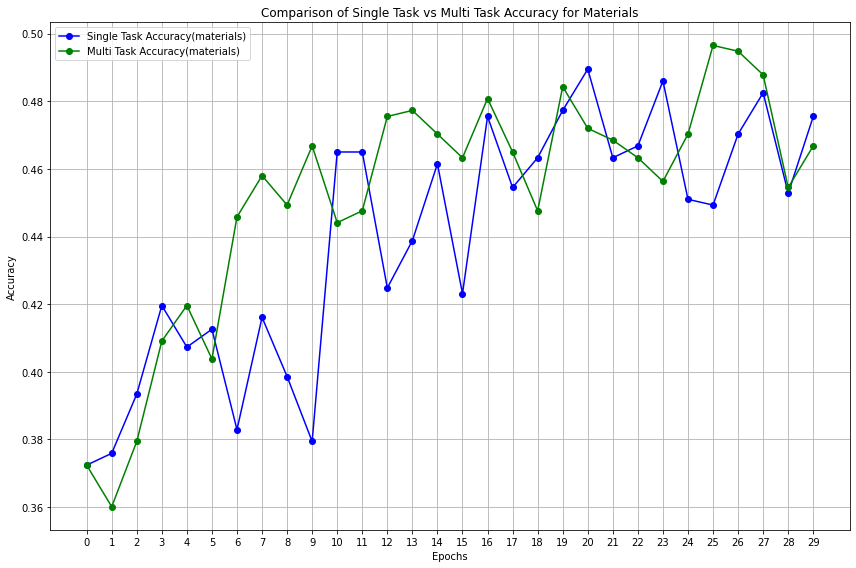

In [9]:
import matplotlib.pyplot as plt


epochs = list(range(30))
val_acc_materials = [0.3724, 0.3759, 0.3934, 0.4196, 0.4073, 0.4126, 0.3829, 0.4161, 0.3986, 0.3794, 0.4650, 0.4650, 0.4248, 0.4388, 0.4615, 0.4231, 0.4755, 0.4545, 0.4633, 0.4773, 0.4895, 0.4633, 0.4668, 0.4860, 0.4510, 0.4493, 0.4703, 0.4825, 0.4528, 0.4755]
val_acc_materials2 = [0.3724, 0.3601, 0.3794, 0.4091, 0.4196, 0.4038, 0.4458, 0.4580, 0.4493, 0.4668, 0.4441, 0.4476, 0.4755, 0.4773, 0.4703, 0.4633, 0.4808, 0.4650, 0.4476, 0.4843, 0.4720, 0.4685, 0.4633, 0.4563, 0.4703, 0.4965, 0.4948, 0.4878, 0.4545, 0.4668]


plt.figure(figsize=(12, 8))

plt.plot(epochs, val_acc_materials, label='Single Task Accuracy(materials)', color='blue', marker='o')
plt.plot(epochs, val_acc_materials2, label='Multi Task Accuracy(materials)', color='green', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Single Task vs Multi Task Accuracy for Materials')
plt.legend()
plt.grid(True)
plt.xticks(epochs) 

plt.tight_layout()
plt.show()


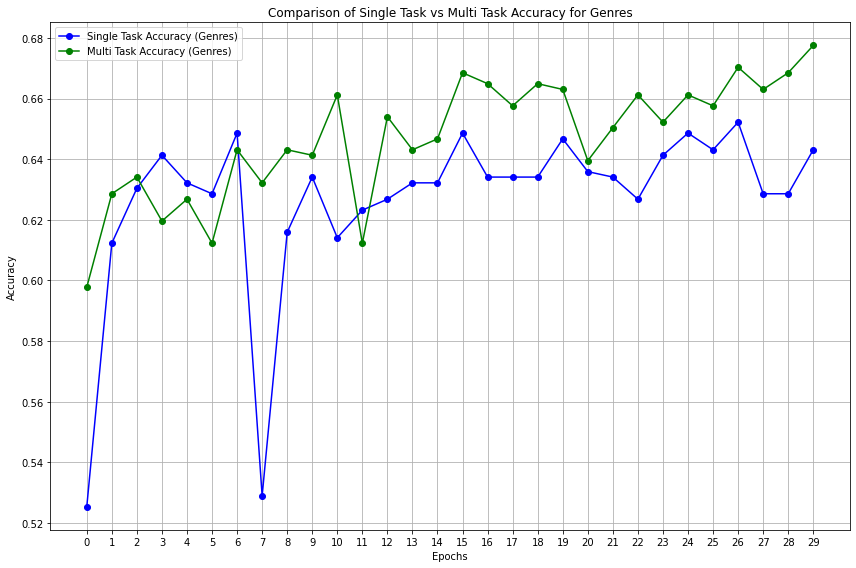

In [12]:
import matplotlib.pyplot as plt


epochs = list(range(30))
val_acc_genres = [0.5254, 0.6123, 0.6304, 0.6413, 0.6322, 0.6286, 0.6486, 0.5290, 0.6159, 0.6341, 0.6141, 0.6232, 0.6268, 0.6322, 0.6322, 0.6486, 0.6341, 0.6341, 0.6341, 0.6467, 0.6359, 0.6341, 0.6268, 0.6413, 0.6486, 0.6431, 0.6522, 0.6286, 0.6286, 0.6431]
val_acc_genres2 = [0.5978, 0.6286, 0.6341, 0.6196, 0.6268, 0.6123, 0.6431, 0.6322, 0.6431, 0.6413, 0.6612, 0.6123, 0.6540, 0.6431, 0.6467, 0.6685, 0.6649, 0.6576, 0.6649, 0.6630, 0.6395, 0.6504, 0.6612, 0.6522, 0.6612, 0.6576, 0.6703, 0.6630, 0.6685, 0.6775]


plt.figure(figsize=(12, 8))

plt.plot(epochs, val_acc_genres, label='Single Task Accuracy (Genres)', color='blue', marker='o')
plt.plot(epochs, val_acc_genres2, label='Multi Task Accuracy (Genres)', color='green', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Single Task vs Multi Task Accuracy for Genres')
plt.legend()
plt.grid(True)
plt.xticks(epochs) 

plt.tight_layout()
plt.show()


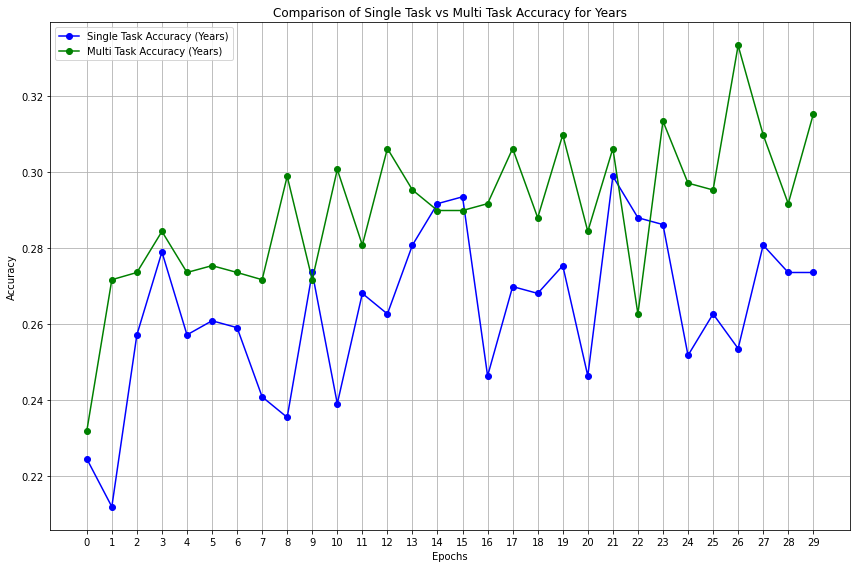

In [11]:
import matplotlib.pyplot as plt


epochs = list(range(30))
val_acc_years = [0.2246, 0.2120, 0.2572, 0.2790, 0.2572, 0.2609, 0.2591, 0.2409, 0.2355, 0.2736, 0.2391, 0.2681, 0.2627, 0.2808, 0.2917, 0.2935, 0.2464, 0.2699, 0.2681, 0.2754, 0.2464, 0.2989, 0.2880, 0.2862, 0.2518, 0.2627, 0.2536, 0.2808, 0.2736, 0.2736]
val_acc_years2= [0.2319, 0.2717, 0.2736, 0.2844, 0.2736, 0.2754, 0.2736, 0.2717, 0.2989, 0.2717, 0.3007, 0.2808, 0.3062, 0.2953, 0.2899, 0.2899, 0.2917, 0.3062, 0.2880, 0.3098, 0.2844, 0.3062, 0.2627, 0.3134, 0.2971, 0.2953, 0.3333, 0.3098, 0.2917, 0.3152]


plt.figure(figsize=(12, 8))

plt.plot(epochs, val_acc_years, label='Single Task Accuracy (Years)', color='blue', marker='o')
plt.plot(epochs, val_acc_years2, label='Multi Task Accuracy (Years)', color='green', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Single Task vs Multi Task Accuracy for Years')
plt.legend()
plt.grid(True)
plt.xticks(epochs)  

plt.tight_layout()
plt.show()
